# COCO BBOB

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import COCO

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LiftedBPC
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.utils import ylim, render
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = 39
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we work with an underlying Linear Dynamical System (LDS) with complex, nonconvex cost functions.

The states $\{x_t\}_{t}$ evolve with
$$x_{t+1} = \begin{cases}x_{t} + u_t & \text{predict_differences is True} \\
u_t & \text{else}\end{cases},$$
where `predict_differences` is set in the system hyperparameters.

The costs are denoted by $f(x_t, u_t)$ and given by problems in the COCO Black Box Optimization suite (http://numbbo.github.io/coco/), which are selected via `problem_idx`. An example cost function is given below (they can be multi-dimensional, but inputs are restricted to lie in $[-5, 5]^{dim}$).

INFO: (COCO): initial state is [2.7212646]


bbob_f021_i05_d02: a 2-dimensional single-objective problem (problem 304 of suite "b'bbob'" with name "BBOB suite problem f21 instance 5 in 2D")


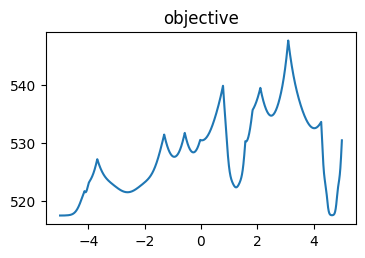

In [25]:
# NEW
# things it works for: 
#       273 (nonconvex), 2010 (sines), 1888 (monotonic), 861 (ez), 682-684 (nonconvex)

# OLD
# things it breaks for:
#       304, 224 & 576 (lil wiggles), 2133 (this ones unfair), 1653 (sucks at wiggles), 1154 (straight line)
# things it looks interesting for:
#       1552 (large basin to explore), 1826 (large scale gives rly large fluctuations), 108 (zoom in on the basin)
# good nonconvex tests:
#       682 and 683 (two local mins, one at 0), 1129 (jaggedy), 1046 (two local mins), 2049

problem_idx = 304 # np.random.randint(2160)

coco = COCO(problem_idx, 
            dim=1, 
            disturbance_type='none', 
            predict_differences=False, 
            seed=SYSTEM_SEED)
print(coco.problem)
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
ax.plot(coco.stats['gt_xs'], coco.stats['gt_fs'])
ax.set_title('objective')
plt.show()

## Hyperparameters

In [21]:
name = 'coco_{}'.format(problem_idx)
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 1500  # total timesteps
    T0 = 500  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: t == T0   # when to reset the system
    use_multiprocessing = False  # can't use on notebooks
    render_every = None  # doesn't work on notebooks

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    dim = 1  # dimension of the optimization
    problem_index = problem_idx  # use the one from plotting earlier
    predict_differences = False

    make_system = lambda : COCO(problem_index, dim, disturbance_type='none', predict_differences=predict_differences, seed=SYSTEM_SEED)

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    sysid_method = 'regression'
    sysid_scale = 6

    learned_lift_args = {
        'lift_lr': 0.01,
        'sysid_lr': 0.01,
        'cost_lr': 0.001,
        'depth': 4,
        'buffer_maxlen': int(1e6),
        'num_epochs': 75,
        'batch_size': 64,
        'seed': LIFTER_AND_SYSID_SEED
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 5  # controller memory length (# of w's to use on inference)
    hh = 5  # history length of the cost/control histories
    lift_dim = 10  # dimension to lift to

    # m_update_rescaler = lambda : FIXED_RESCALE(alpha=0.1, beta=0.9)
    # m0_update_rescaler = lambda : FIXED_RESCALE(alpha=0.1, beta=0.9)
    # k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.00, beta=0)

    m_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
    k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))

    lifted_bpc_args = {
        'h': h,
        'method': 'REINFORCE',
        'initial_scales': (0.01, 1., 0.),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'T0': T0,
    #     'bounds': (-0.1, 0.1),
        'initial_u': jnp.zeros(dim),
        'decay_scales': True,
        'use_tanh': False,
        'use_K_from_sysid': False,
        'seed': CONTROLLER_SEED
    }

    make_controllers = {
    #     'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, dim, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, dim, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    #     'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, dim, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, dim, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
        'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, dim, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
    }
    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [22]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing Learned Lift
INFO: (COCO): initial state is [2.7212646]
 32%|███████████████████▉                                          | 483/1500 [00:02<00:04, 226.97it/s, state=-1.62, control=0.369, cost=92.4]INFO: (LIFTEDBPC) Note that we are only updating lifter during sysid phase
INFO: (LEARNEDLIFT): training!
INFO: (LEARNEDLIFT) 	mean loss for past 25 epochs was 0.7854788814272199
INFO: (LEARNEDLIFT) 	mean loss for past 25 epochs was 0.25413825511932375
INFO: (LEARNEDLIFT) 	mean loss for past 25 epochs was 0.1373964488506317
INFO: (LEARNEDLIFT) 	mean loss for past 25 epochs was 0.09825443863868713
INFO: (LEARNEDLIFT) ||A||_op = 1.000937819480896     ||B||_F 1.0
 32%|███████████████████▉                                          | 483/1500 [00:03<00:04, 226.97i

In [5]:
# # save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
# #                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [19]:
def plot_coco(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot system stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)

        stats.plot(ax[2, 0], 'fs', label=method)
        stats.plot(ax[2, 1], 'median fs since last reset', label=method)

        stats.plot(ax[3, 0], '||A||_op', label=method)
        stats.plot(ax[3, 1], '||B||_F', label=method)
        stats.plot(ax[4, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 1], 'cost diffs', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend(); ylim(_ax, -20, 20)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, -3, 3)
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous costs'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('median costs since last reset'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[4, 1]; _ax.set_title('cost diffs'); _ax.legend()
    
    # plot the true COCO objective
    _ax = ax[1, 1]
    if stats.aggregated: _ax.plot(stats['gt_xs'][0], stats['gt_fs'][0])
    else: _ax.plot(stats['gt_xs'], stats['gt_fs'])
    _ax.set_title('objective'); _ax.set_xlim(-5, 5)
    pass

### Plot

<Figure size 640x480 with 0 Axes>

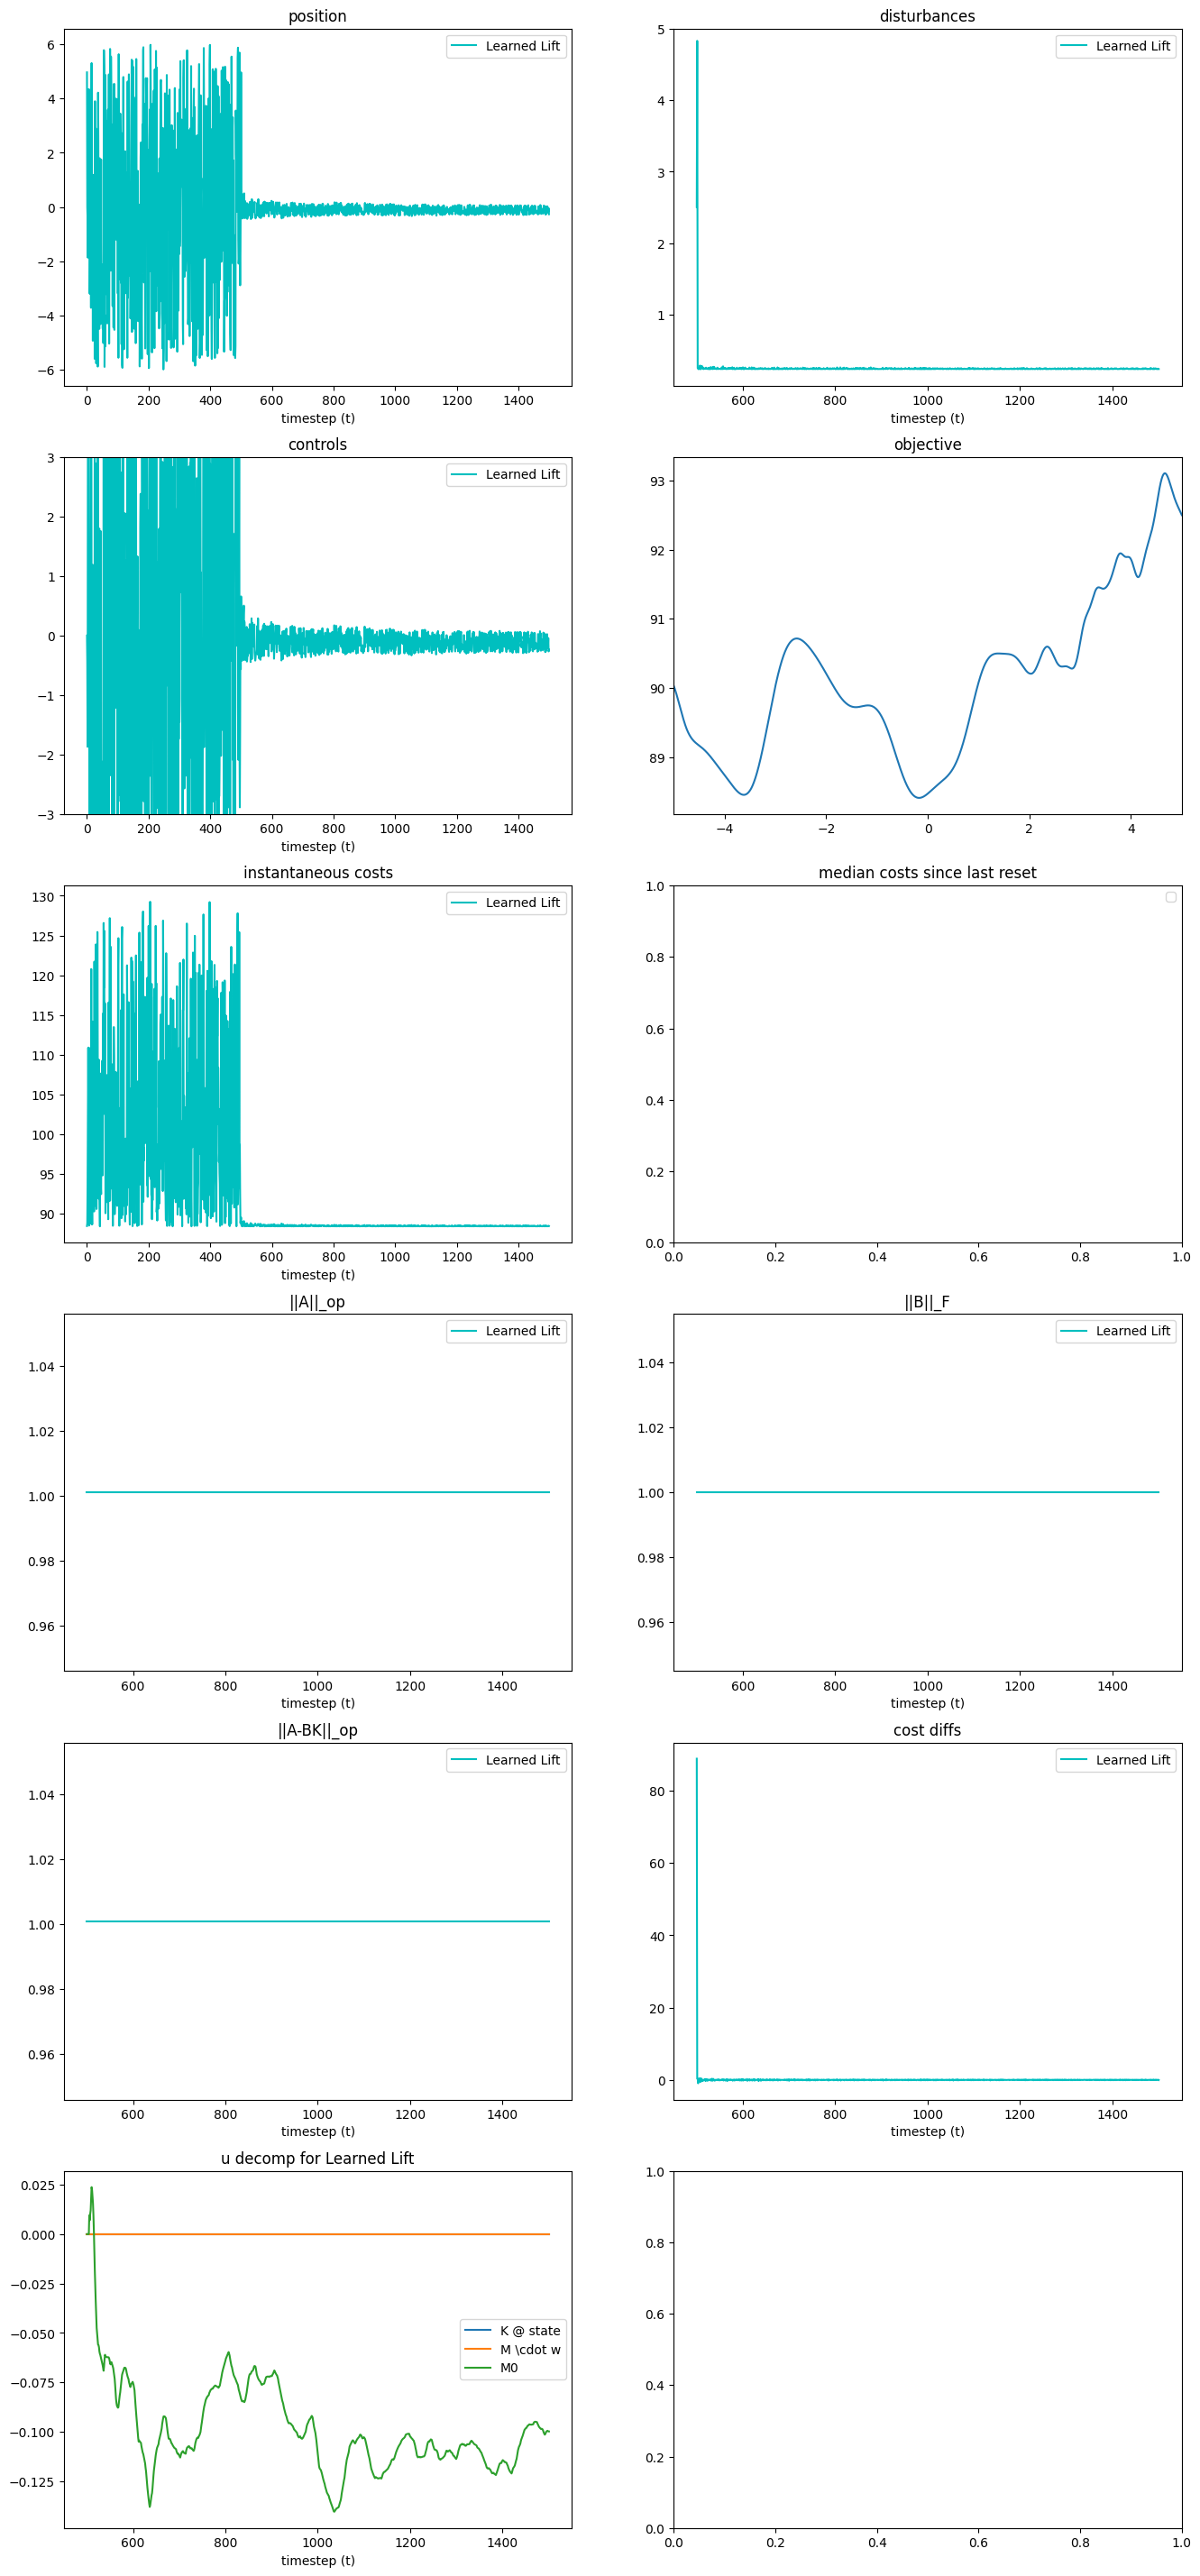

In [23]:
plot_coco(experiment)

### Dynamic Plot

In [8]:
# dynamic plot
anim = render(experiment, 'xs', 'fs', sliderkey='us', save_path=None, duration=5, fps=30)
vid = anim.to_html5_video()
HTML(vid)

INFO: (RENDERER): rendering the stats of the following: ['Learned Lift']
INFO: (STATS): prepared to render ('xs', 'fs') over time with slider us!
INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -r 29.999999999999996 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpa81igz1o/temp.m4v
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/extravaganza/utils.py:98: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xl, xr + 1e-8)
